# Customer Analysis with Clustering

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
np.random.seed(73)

In [2]:
df = pd.read_csv('C:/_local/data_sets/marketing_campaign.csv',
                 sep='\t',
                 parse_dates=['Dt_Customer'],
                 infer_datetime_format=True)

In [4]:
print(f'data shape: {df.shape}')
df.head()

data shape: (2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-04-09,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-08-03,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-10-02,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [5]:
df['Income_na'] = df['Income'].isnull().astype(int).astype('category')
df['Income'] = df['Income'].fillna(df['Income'].mean())

In [6]:
latest_date = df['Dt_Customer'].max()
df['Dt_Customer_Days'] = (latest_date - df['Dt_Customer']).dt.days

df['Customer_Age'] = 2021-df['Year_Birth']

df['Total_Spendage'] = (df['MntWines'] + df['MntFruits'] + 
                        df['MntFishProducts'] + df['MntSweetProducts'] +
                        df['MntGoldProds']
                       )

marital_household_size_dict = {'Single': 1, 'Divorced': 1,
                               'Widow': 1, 'Alone': 1,
                               'Absurd': 1, 'YOLO': 1,
                               'Together': 2, 'Married': 2}

def get_household_size(x):
    return (marital_household_size_dict[x['Marital_Status']] +
            x['Kidhome'] + x['Teenhome']
           )

df['Household_Size'] = (df[['Marital_Status', 'Kidhome', 'Teenhome']]
                        .apply(get_household_size, axis=1)
                       )

df['Children'] = df['Kidhome'] + df['Teenhome']

df['Education'] = df['Education'].replace({
    'Basic': 1, '2n Cycle': 1, 
    'Graduation': 2, 'Master': 2, 'PhD': 3
})
df['Education'] = df['Education'].map(lambda x: (x-.5)/3)

cmp_accepted_strings = []
for i in range(1,6):
    cmp_accepted_strings.append('AcceptedCmp'+str(i))

for s in cmp_accepted_strings:
    df[s] = df[s].replace({1: .3})
    
df['TotalCmpAccepted'] = (df
                          [cmp_accepted_strings]
                          .apply(lambda x: np.sum(x)/.3, axis=1)
                          .astype(int)
                         )

df['Complain'] = df['Complain'].replace({1: .5})

df.drop(['Marital_Status', 'Dt_Customer', 'Year_Birth', 'ID',
         'Z_CostContact', 'Z_Revenue'], 
        axis=1, inplace=True)

df['Customer_Age'].where(df['Customer_Age'] <= 90, 90, inplace=True)
df['Income'].where(df['Income'] <= 130000, 130000, inplace=True)

df['Response'] = df['Response'].astype('category')

In [7]:
df.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Income_na', 'Dt_Customer_Days',
       'Customer_Age', 'Total_Spendage', 'Household_Size', 'Children',
       'TotalCmpAccepted'],
      dtype='object')

In [8]:
X = df.drop(['Response'], axis=1)
y = df['Response']

category_vars = ['Education', 
                 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
                 'Complain', 'Response']
numeric_vars = list(set(X.columns) - set(category_vars))

scaler = StandardScaler().fit(X[numeric_vars])

X[numeric_vars] = scaler.transform(X[numeric_vars])

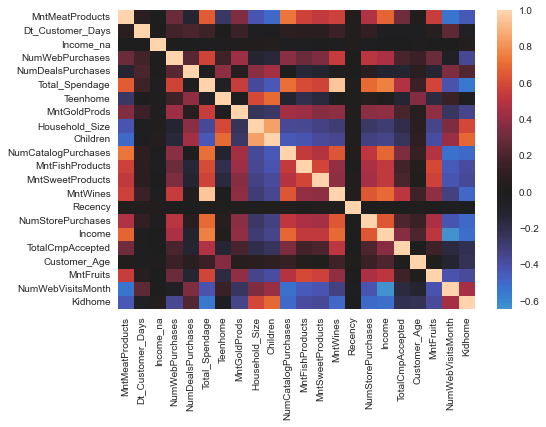

In [9]:
sns.heatmap(X[numeric_vars].corr(), center=0);

In [10]:
pca_3 = PCA(n_components=3).fit(X)
pca_3_df = pd.DataFrame(pca_3.transform(X), 
                        columns=['pc_1', 'pc_2', 'pc_3'])
pca_3_df.head()

,pc_1,pc_2,pc_3
0,4.480685,-0.065670,2.295207
1,-2.899565,0.235691,-2.356446
2,2.268390,-0.690718,-0.051685
3,-2.711339,-1.709590,-0.383836
4,-0.527142,-0.042164,0.357319


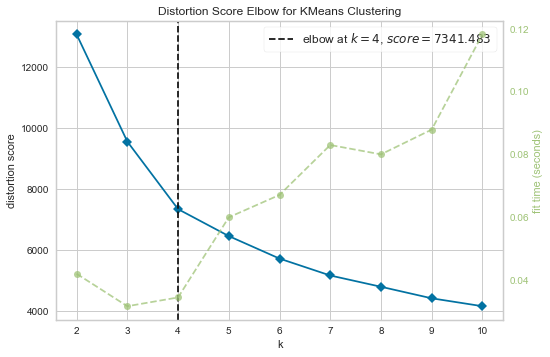

In [11]:
elbow = KElbowVisualizer(KMeans(), k=10).fit(pca_3_df)
elbow.show();

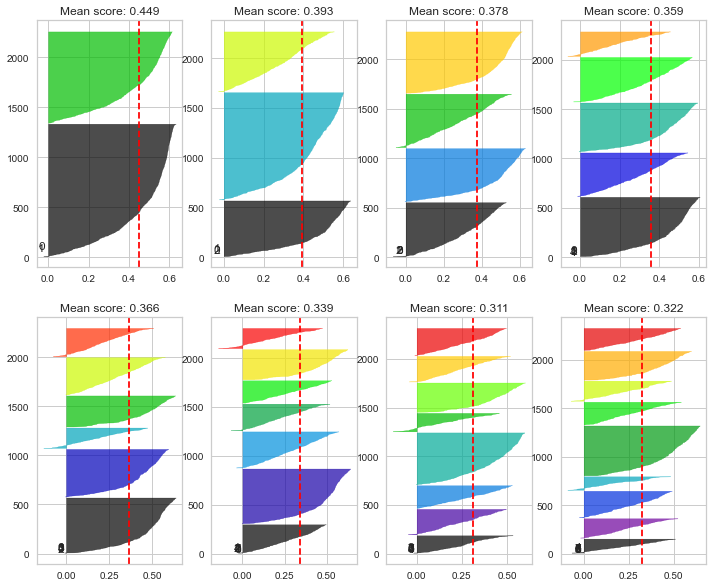

In [12]:
fig, axs = plt.subplots(2, 4, figsize=(12,10))

for i in range(2):
    for j in range(4):
        K = (i*4)+(j+2)
        #axs[i,j].set_xlim([-.1, 1])
        
        cluster_labels = KMeans(n_clusters=K, random_state=75).fit_predict(pca_3_df)
        silhouette_mean = silhouette_score(pca_3_df, cluster_labels)
        silhouette_scores = silhouette_samples(pca_3_df, cluster_labels)
        
        y_lower=10
        for k in range(K):
            kth_cluster_silhouette_values = silhouette_scores[cluster_labels == k]
            kth_cluster_silhouette_values.sort()
            kth_cluster_size = kth_cluster_silhouette_values.shape[0]
            y_upper = y_lower + kth_cluster_size
            
            color = cm.nipy_spectral(float(k) / K)
            axs[i,j].fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                kth_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=.7
            )
            axs[i,j].text(-.05, 10+.05 * kth_cluster_size, str(k))
            y_lower = 10 + y_upper
        
        axs[i,j].set_title(f'Mean score: {round(silhouette_mean, 3)}')
        axs[i,j].axvline(x=silhouette_mean, color='red', linestyle='--')
            
plt.show()

In [13]:
kmeans = KMeans(n_clusters=4).fit(pca_3_df)
agglor = AgglomerativeClustering(n_clusters=4)

kmeans_preds = kmeans.predict(pca_3_df)
agglor_preds = agglor.fit_predict(pca_3_df)

In [14]:
cluster_differ_table = (pd.DataFrame({'k': kmeans_preds, 'a': agglor_preds})
                        .value_counts()
                       )
print(cluster_differ_table.head(7))

cluster_map = list(cluster_differ_table.iloc[:4].index)
cluster_map = {k:v for k,v in cluster_map}
cluster_map

k  a
3  3    596
0  2    512
1  0    508
2  1    433
   0     83
1  3     27
0  1     17
dtype: int64


{3: 3, 0: 2, 1: 0, 2: 1}

In [15]:
preds = pd.DataFrame({'kmeans_preds': kmeans_preds,
                      'agglor_preds': agglor_preds})
preds['kmeans_preds'] = preds['kmeans_preds'].replace(cluster_map)
preds['differ?'] = (preds['kmeans_preds'] != preds['agglor_preds']).astype(int)

df = pd.concat([df, preds], axis=1)

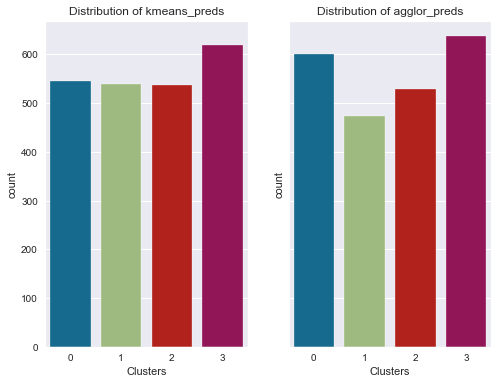

In [16]:
sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 6))
for col, ax in zip(preds.columns, axs):
    sns.countplot(x=preds[col], ax=ax);
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('Clusters')

plt.show()

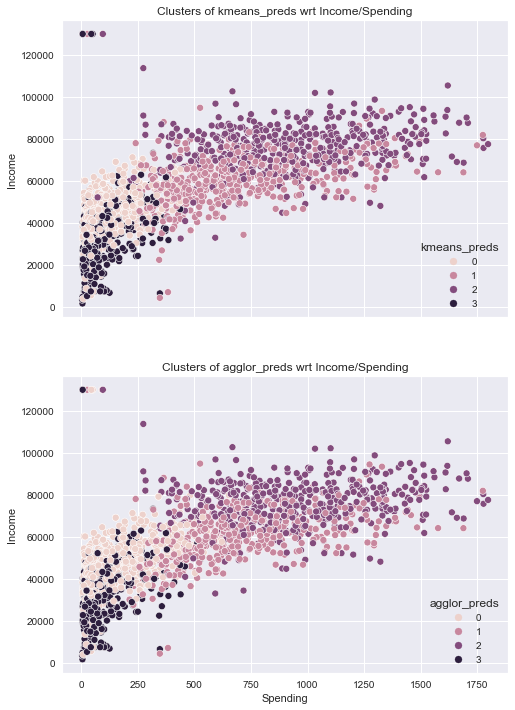

In [17]:
sns.set_style('darkgrid')
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 12))
for col, ax in zip(preds.columns, axs):
    sns.scatterplot(data=df, x=df['Total_Spendage'], y=df['Income'],
                    hue=df[col], ax=ax)
    ax.set_title(f'Clusters of {col} wrt Income/Spending')
    ax.set_ylabel('Income')
    ax.set_xlabel('Spending')
    ax.label_outer()
    
plt.show()

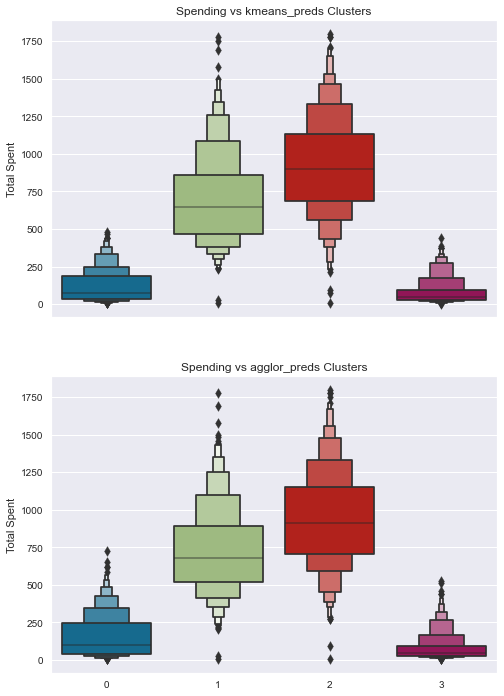

In [18]:
sns.set_style('darkgrid')
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 12))
for col, ax in zip(preds.columns, axs):
    sns.boxenplot(x=df[col], y=df['Total_Spendage'], ax=ax)
    ax.set_ylabel('Total Spent')
    ax.set_title(f'Spending vs {col} Clusters')
    ax.set_xlabel('')

plt.show()

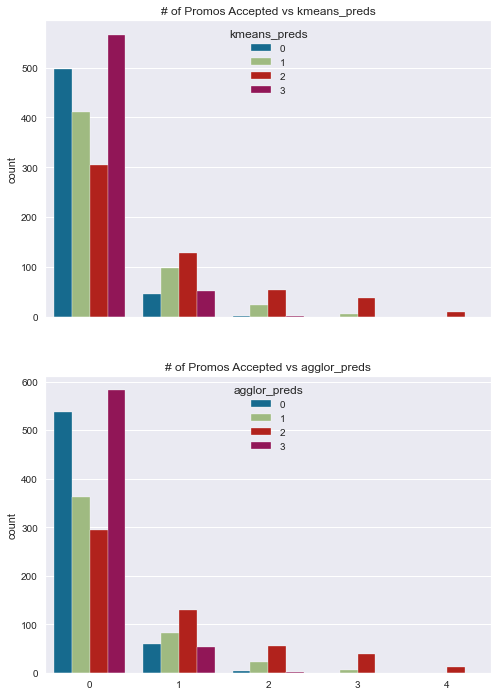

In [19]:
sns.set_style('darkgrid')
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 12))
for col, ax in zip(preds.columns, axs):
    sns.countplot(x=df['TotalCmpAccepted'], hue=df[col], ax=ax);
    ax.set_title(f'# of Promos Accepted vs {col}')
    ax.set_xlabel('')
    ax.set_ylabel('count')
    
plt.show()

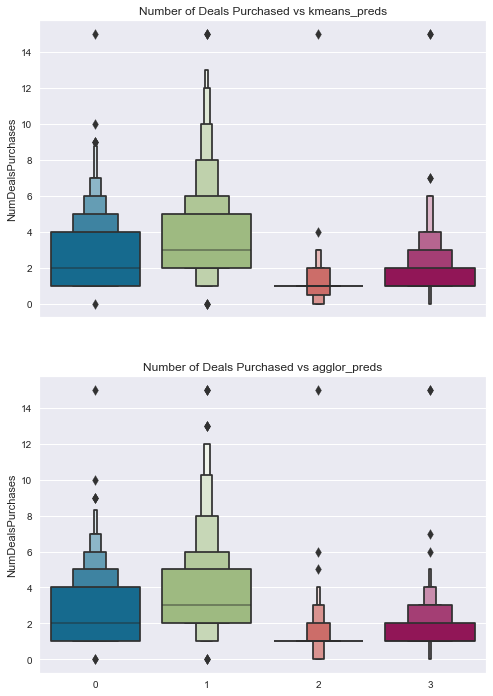

In [20]:
sns.set_style('darkgrid')
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 12))
for col, ax in zip(preds.columns, axs):
    sns.boxenplot(x=df[col], y=df['NumDealsPurchases'], ax=ax)
    ax.set_title(f'Number of Deals Purchased vs {col}')
    ax.set_xlabel('')
    
plt.show()

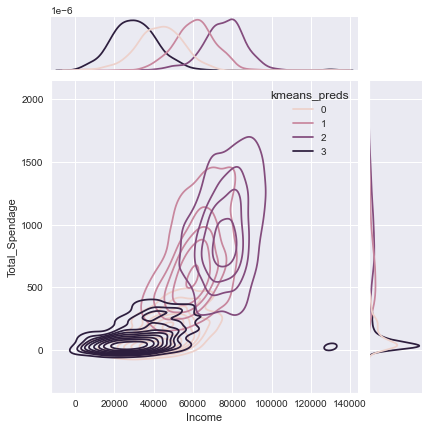

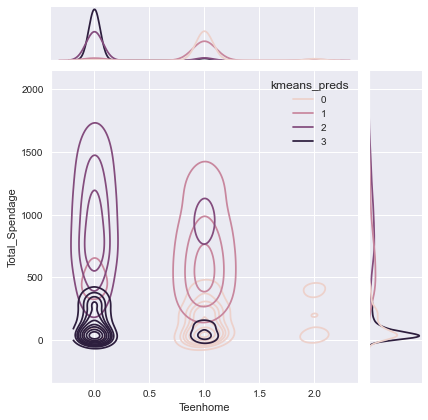

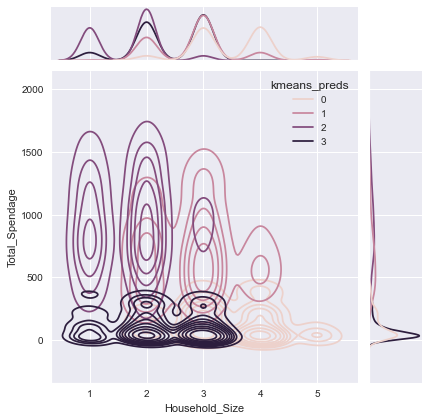

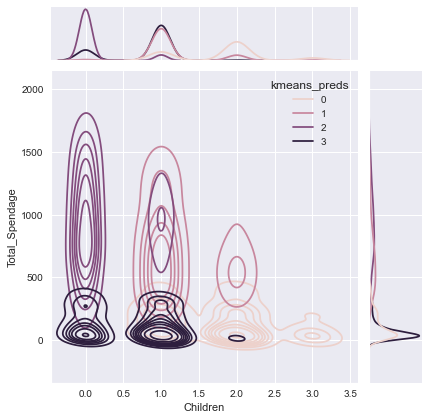

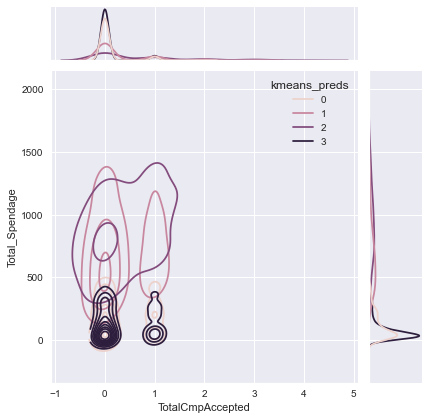

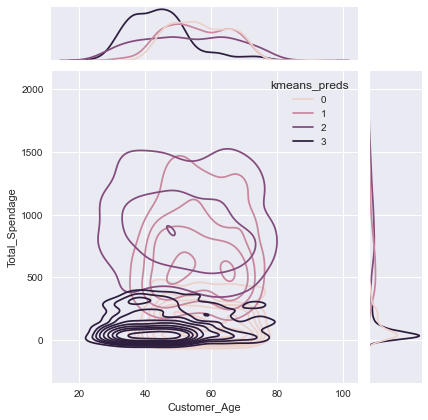

In [21]:
profiling_variables = ['Income', 'Teenhome', 'Household_Size', 
                       'Children', 'TotalCmpAccepted', 'Customer_Age']

sns.set_style('darkgrid')
#fig, axs = plt.subplots(3, 2)

for i in range(3):
    for j in range(2):
        var = profiling_variables[2*i+j]
        sns.jointplot(x=df[var], y=df['Total_Spendage'], hue=df['kmeans_preds'], kind='kde', 
                      #ax=axs[i,j]
                     );
        plt.show()
